<a href="https://colab.research.google.com/github/styxx216/ML/blob/main/MNIST_digit_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn,optim
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms, utils

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [26]:
train_path='/content/drive/MyDrive/datasets/mnist/train.csv'
test_path='/content/drive/MyDrive/datasets/mnist/test.csv'
submission_path='/content/drive/MyDrive/datasets/mnist/sample_submission.csv'

In [27]:
train=pd.read_csv(train_path)

In [ ]:
train.iloc[1:5]

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
class MNIST_dataset(Dataset):
  def __init__(self,path,transform,targets=True):
    data=pd.read_csv(path)
    self.features=data.iloc[:,1:]
    self.targets=data['label']
    self.transform = transform
  def __len__(self):
    return len(self.features)
  def __getitem__(self, idx):
    res=self.features.iloc[idx]
    image=torch.Tensor(np.array(res).reshape([1,28,28])/225)
    label=self.targets[idx]
    if self.transform:
     image = self.transform(image)
    return image,label

In [ ]:
transforms.RandomHorizontalFlip

torchvision.transforms.transforms.RandomHorizontalFlip

In [28]:
TR=transforms.Compose([transforms.RandomRotation(25),transforms.Resize((28,28))])
set=MNIST_dataset(train_path,TR)
validation_split = 0.2

train_set, val_set = torch.utils.data.random_split(set, [int(len(set)*(1-validation_split)), int(len(set)*validation_split)])

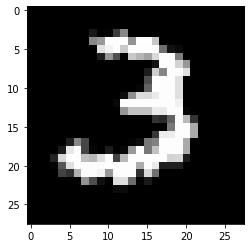

In [29]:
img,_=set[9]
plt.imshow((img[0]),cmap='gray')

In [45]:
loader=DataLoader(train_set,batch_size=64, shuffle=True)
test_loader=DataLoader(val_set,batch_size=1, shuffle=True)

In [46]:
class Classifier(nn.Module):
    def __init__(self,n=64):
        super().__init__()
        self.conv_1=nn.Conv2d(1,n,kernel_size=5,padding=2,stride=1)#28
        self.relu_1=nn.ReLU()
        self.maxpool_1=nn.MaxPool2d(kernel_size=2,stride=2)#14

        self.conv_2=nn.Conv2d(n,n*2,kernel_size=3,padding=1,stride=1)#14
        self.relu_2=nn.ReLU()
        self.maxpool_2=nn.MaxPool2d(kernel_size=2,stride=2)#7

        self.conv_3=nn.Conv2d(n*2,n*4,kernel_size=2,padding=1,stride=1)#7
        self.relu_3=nn.ReLU()
        self.maxpool_3=nn.MaxPool2d(kernel_size=2,stride=2)#4

        self.conv_4=nn.Conv2d(n*4,n*8,kernel_size=2,padding=1,stride=1)#4
        self.relu_4=nn.ReLU()
        self.maxpool_4=nn.MaxPool2d(kernel_size=2,stride=2)#2

        self.conv_5=nn.Conv2d(n*8,n*16,kernel_size=2,padding=1,stride=1)#2
        self.relu_5=nn.ReLU()
        self.maxpool_5=nn.MaxPool2d(kernel_size=2,stride=2)#1

        self.dropout=nn.Dropout(0.2)
        self.flatten=nn.Flatten()

        self.fc1=nn.Linear(n*16,4000)
        self.fc2=nn.Linear(4000,512)
        self.fc3=nn.Linear(4000,10)

        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        out=self.conv_1(x)
        out=self.relu_1(out)
        out=self.maxpool_1(out)

        out=self.conv_2(out)
        out=self.relu_2(out)
        out=self.maxpool_2(out)

        out=self.conv_3(out)
        out=self.relu_3(out)
        out=self.maxpool_3(out)

        out=self.conv_4(out)
        out=self.relu_4(out)
        out=self.maxpool_4(out)

        out=self.conv_5(out)
        out=self.relu_5(out)
        out=self.maxpool_5(out)

        out=self.dropout(out)
        out=self.flatten(out)

        out=self.fc1(out)
        out=self.dropout(out)
        #out=self.fc2(out)
        out=self.dropout(out)
        out=self.fc3(out)

        #out=self.sigmoid(out)
        return out

In [47]:
model = Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)
optimizer =optim.Adam(model.parameters(), lr = 1e-6)
model = model.to(device)

In [48]:
def test_model(model,testloader):
  total = 0
  correct = 0
  with torch.no_grad():
      model.eval()
      for images, labels in testloader:
        images=images.to(device)
        labels=labels.to(device)

        outputs = model(images.float())
        predicted = torch.argmax(outputs,dim=1)
        total += len(labels)
        correct += (predicted == labels).sum()
                  
  accuracy = correct / float(total)
  return accuracy

In [69]:
epochs = 20
losses = []
acc=[]
test_acc=[]
for i in range(epochs):
  running_loss = 0
  for j,(images,labels) in enumerate(loader):
    print(images.size())
    images=images.to(device)
    labels=labels.to(device)
    predicted=model(images.float())
    print(torch.argmax(predicted, dim=1),labels)
    loss=criterion(predicted,labels)
    running_loss+=loss
    loss.backward()
    optimizer.step()
  acc.append(test_model(model,loader))
  test_acc.append(test_model(model,test_loader))
  epoch_loss = running_loss / len(loader)
  losses.append(epoch_loss)

Выходные данные были обрезаны до нескольких последних строк (5000).
        1, 6, 7, 1, 6, 9, 8, 1, 6, 7, 4, 0, 4, 7, 5, 5, 7, 8, 3, 1, 7, 1, 0, 1,
        0, 5, 6, 6, 2, 5, 9, 9, 3, 5, 9, 7, 1, 8, 8, 5], device='cuda:0')
torch.Size([64, 1, 28, 28])
tensor([6, 0, 2, 6, 1, 0, 0, 0, 7, 5, 8, 4, 9, 9, 5, 3, 3, 9, 9, 0, 9, 6, 4, 3,
        1, 4, 3, 1, 2, 5, 7, 1, 5, 6, 0, 7, 5, 0, 0, 2, 6, 1, 5, 7, 8, 0, 0, 7,
        7, 2, 3, 0, 8, 8, 2, 4, 2, 4, 0, 8, 3, 8, 6, 8], device='cuda:0') tensor([6, 0, 2, 6, 1, 0, 0, 0, 7, 5, 8, 4, 9, 9, 5, 3, 3, 9, 9, 0, 9, 6, 4, 3,
        1, 4, 3, 1, 2, 5, 7, 1, 5, 6, 0, 7, 5, 0, 0, 2, 6, 1, 5, 7, 8, 0, 0, 7,
        7, 2, 3, 0, 8, 8, 2, 4, 2, 4, 0, 8, 3, 8, 6, 8], device='cuda:0')
torch.Size([64, 1, 28, 28])
tensor([0, 2, 0, 3, 1, 1, 1, 0, 8, 3, 8, 7, 7, 9, 7, 5, 1, 5, 1, 9, 7, 5, 5, 4,
        0, 9, 7, 0, 0, 2, 3, 1, 7, 9, 1, 0, 6, 0, 6, 4, 6, 2, 0, 4, 3, 2, 2, 2,
        0, 2, 6, 0, 3, 8, 1, 7, 2, 4, 5, 0, 3, 7, 5, 3], device='cuda:0') tensor([0, 2, 0, 3, 

In [52]:
print(test_acc)

[tensor(0.3249, device='cuda:0'), tensor(0.4832, device='cuda:0'), tensor(0.6206, device='cuda:0'), tensor(0.4730, device='cuda:0'), tensor(0.5344, device='cuda:0'), tensor(0.6265, device='cuda:0'), tensor(0.7568, device='cuda:0'), tensor(0.7940, device='cuda:0'), tensor(0.8181, device='cuda:0'), tensor(0.8520, device='cuda:0'), tensor(0.8440, device='cuda:0'), tensor(0.8902, device='cuda:0'), tensor(0.8806, device='cuda:0'), tensor(0.9082, device='cuda:0'), tensor(0.9246, device='cuda:0'), tensor(0.9348, device='cuda:0'), tensor(0.9377, device='cuda:0'), tensor(0.9456, device='cuda:0'), tensor(0.9481, device='cuda:0'), tensor(0.9508, device='cuda:0')]


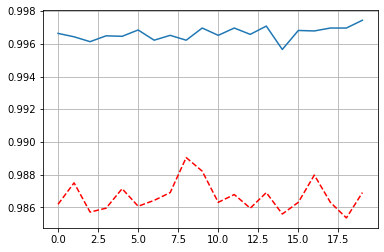

In [70]:
plt.plot(range(len(test_acc)),test_acc,'r--',range(len(acc)),acc)
plt.grid(True)

In [71]:
class test_dataset(Dataset):
  def __init__(self,path):
    data=pd.read_csv(path)
    self.features=data
  def __len__(self):
    return len(self.features)
  def __getitem__(self, idx):
    res=self.features.iloc[idx]
    res= torch.Tensor(np.array(res).reshape([1,1,28,28])/225)
    res=res.to(device)
    return res
    

In [72]:
test=test_dataset(test_path)
submission=pd.read_csv(submission_path)

In [73]:
for i in range(len(test)):
  n=int(torch.argmax(model(test[i])))
  print(n)
  submission['Label'][i]=n

Выходные данные были обрезаны до нескольких последних строк (5000).
4
6
7
4
6
9
6
4
7
8
8
0
5
2
4
6
0
6
6
5
0
5
1
5
7
7
3
7
0
3
0
3
5
3
8
7
6
0
9
3
5
0
2
7
6
6
4
7
8
7
1
1
2
9
6
1
0
2
2
8
1
3
5
2
5
9
8
8
6
6
5
0
1
6
9
5
2
7
2
3
4
1
8
9
4
0
7
2
1
0
9
5
6
8
0
3
5
7
5
5
8
7
2
3
6
1
1
9
5
3
1
3
3
6
8
3
5
0
7
1
5
8
5
5
6
1
3
2
8
1
1
9
8
5
9
5
5
1
7
1
1
6
5
7
2
3
3
5
7
3
9
2
3
5
1
6
8
7
7
0
3
6
7
1
9
6
3
7
0
6
9
4
2
1
1
2
9
8
3
2
0
2
3
7
6
9
6
6
6
4
6
1
0
2
3
0
4
7
6
8
8
7
2
6
3
2
2
4
7
0
0
1
0
0
0
3
8
1
8
0
1
9
3
0
9
5
5
5
5
1
3
8
7
3
2
0
6
6
6
7
4
1
7
5
2
1
4
7
2
4
0
6
4
4
5
1
5
8
8
7
7
7
1
5
4
6
7
2
7
1
5
9
9
7
8
2
1
8
6
6
1
4
1
0
0
2
1
2
8
9
7
2
9
5
7
0
8
0
0
0
7
3
5
4
1
4
0
2
0
0
2
2
8
3
5
6
8
7
2
4
3
9
6
4
9
5
6
1
2
3
1
1
2
2
3
2
7
0
6
9
0
1
0
8
8
6
4
2
0
9
9
6
1
6
7
9
0
1
3
1
2
7
8
9
1
9
1
0
7
6
5
0
5
3
5
5
8
7
3
3
2
3
3
6
6
3
1
1
4
6
8
5
3
9
5
4
1
6
7
0
2
0
8
1
7
5
2
8
3
3
1
1
3
2
0
8
1
6
8
3
0
3
0
4
2
4
8
1
3
2
3
6
5
8
3
7
0
1
9
8
0
8
0
5
6
1
4
8
7
1
3
4
0
3
6
3
0
3
8
4
5
8
1
2
0
4


In [74]:
submission.to_csv('/content/drive/MyDrive/datasets/mnist/submission10.csv',index=False)